In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from lifelines import KaplanMeierFitter


# Loading the Data and Cleaning

In [2]:
# load the data sets
customerdf = pd.read_csv('customer_metadata.csv')
accountsdf = pd.read_csv('account_segments.csv')
integrationsdf = pd.read_csv('integrations.csv')

In [3]:
customerdf['CUSTOMER_CANCELLATION_DOLLARS'].fillna(0, inplace=True)
customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].fillna(0, inplace=True)
customerdf['CUSTOMER_VALUE_END_OF_MONTH'].fillna(0, inplace=True)
customerdf = customerdf.dropna(subset=['PRODUCT_TIER'])
customerdf['PRODUCT_TIER'] = customerdf['PRODUCT_TIER'].replace('Ent', 'Enterprise')
customerdf.head(100)

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS
0,H00041533,2020-09,Pro,5,"$1,440.00","$1,440.00",0
1,H00041533,2020-10,Pro,5,"$1,440.00","$1,480.00",0
2,H00041533,2020-11,Pro,5,"$1,480.00","$1,480.00",0
3,H00041533,2021-01,Pro,8,"$1,480.00","$1,560.00",0
4,H00041533,2020-12,Pro,8,"$1,480.00","$1,480.00",0
...,...,...,...,...,...,...,...
95,H00043306,2020-09,Pro,3,"$1,100.00","$1,100.00",0
96,H00043306,2020-08,Pro,3,"$1,100.00","$1,100.00",0
97,H00043488,2020-10,Pro,1,$40.00,$40.00,0
98,H00043488,2020-11,Pro,1,$40.00,0,-$40.00


In [4]:
print(customerdf.isnull().sum())
total_rows = customerdf.shape[0]
print("Total number of rows:", total_rows)

CUSTOMER_ID                          0
SNAPSHOT_MONTH                       0
PRODUCT_TIER                         0
NUM_OF_INTEGRATIONS                  0
CUSTOMER_VALUE_BEGINNING_OF_MONTH    0
CUSTOMER_VALUE_END_OF_MONTH          0
CUSTOMER_CANCELLATION_DOLLARS        0
dtype: int64
Total number of rows: 273982


In [5]:
accountsdf.head()

,CUSTOMER_ID,EMPLOYEE_SIZE,CUSTOMER_SEGMENT
0,H00041533,1 to 25,International Direct
1,H00041565,26 to 200,NAM Direct
2,H00041874,26 to 200,NAM Partner
3,H00041885,26 to 200,International Partner
4,H00042047,1 to 25,NAM Low-Touch


In [6]:
integrationsdf.head()

,INTEGRATION_ID,CUSTOMER_ID,SNAPSHOT_MONTH
0,1,H00041533,2020-08-01
1,7,H00041533,2020-08-01
2,8,H00041533,2020-08-01
3,11,H00041533,2020-08-01
4,15,H00041533,2020-08-01


In [7]:
# Filter the DataFrame for rows where INTEGRATION_ID starts with "CUSTOM"
custom_integrations = integrationsdf[integrationsdf['INTEGRATION_ID'].str.startswith('CUSTOM', na=False)]

# Check for duplicates in the INTEGRATION_ID column 
duplicate_custom_integrations = custom_integrations.duplicated(subset=['INTEGRATION_ID'], keep=False)

# Display rows where INTEGRATION_ID has duplicates
duplicates_df = custom_integrations[duplicate_custom_integrations]
# Are there dupes? 
any_duplicates = duplicate_custom_integrations.any()

print(f"Are there any duplicates for INTEGRATION_IDs starting with 'CUSTOM'?: {any_duplicates}")

# If you want to see the duplicates
if any_duplicates:
    print("Here are the duplicate INTEGRATION_IDs that start with 'CUSTOM':")
    print(duplicates_df)

Are there any duplicates for INTEGRATION_IDs starting with 'CUSTOM'?: False


In [8]:
# Count the number of observations in the 'integration_id' column containing the word 'custom'
num_custom_integrations = integrationsdf['INTEGRATION_ID'].str.contains('Custom', case=False).sum()

# Display the result
print("Number of observations with 'custom' in the 'integration_id' column:", num_custom_integrations)

Number of observations with 'custom' in the 'integration_id' column: 207836


In [9]:
# Update the INTEGRATION_ID column
integrationsdf.loc[integrationsdf['INTEGRATION_ID'].str.startswith('Custom', na=False), 'INTEGRATION_ID'] = 'Custom'

integrationsdf.head(100)

,INTEGRATION_ID,CUSTOMER_ID,SNAPSHOT_MONTH
0,1,H00041533,2020-08-01
1,7,H00041533,2020-08-01
2,8,H00041533,2020-08-01
3,11,H00041533,2020-08-01
4,15,H00041533,2020-08-01
...,...,...,...
95,10,H00143460,2020-08-01
96,2,H00143790,2020-08-01
97,10,H00143790,2020-08-01
98,4,H00143790,2020-08-01


In [10]:
integrationsdf['SNAPSHOT_MONTH'] = pd.to_datetime(integrationsdf['SNAPSHOT_MONTH'])
integrationsdf_jan_21 = integrationsdf[integrationsdf['SNAPSHOT_MONTH'] == '2021-01']
integrationsdf_jan_21.head()

,INTEGRATION_ID,CUSTOMER_ID,SNAPSHOT_MONTH
725669,1,H00041533,2021-01-01
725670,7,H00041533,2021-01-01
725671,8,H00041533,2021-01-01
725672,11,H00041533,2021-01-01
725673,15,H00041533,2021-01-01


# Exploratory 

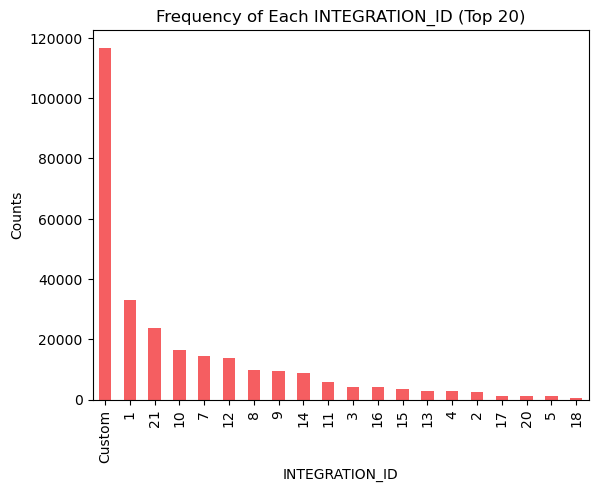

In [11]:
# Plot the top 20 most frequent INTEGRATION_IDs
id_counts = integrationsdf_jan_21['INTEGRATION_ID'].value_counts()
id_counts.head(20).plot(kind='bar', color= '#f55e61')
plt.title('Frequency of Each INTEGRATION_ID (Top 20)')
plt.xlabel('INTEGRATION_ID')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

In [12]:
row_count = integrationsdf_jan_21.shape[0]
print("Number of rows in integrationsdf_jan_21:", row_count)

Number of rows in integrationsdf_jan_21: 277563


In [13]:
# Count the number of observations in the 'integration_id' column containing the word 'custom'
num_custom_integrations_jan_21 = integrationsdf_jan_21['INTEGRATION_ID'].str.contains('Custom', case=False).sum()

# Display the result
print("Number of observations with 'custom' in the 'integration_id' column:", num_custom_integrations_jan_21)

Number of observations with 'custom' in the 'integration_id' column: 116732


In [14]:
row_count = integrationsdf.shape[0]
print("Number of rows in integrationsdf:", row_count)

Number of rows in integrationsdf: 1003232


In [15]:
##Avg # of integrations in Jan 2021

# Filter the DataFrame for SNAPSHOT_MONTH being '01-2021'
jan_df = customerdf[customerdf['SNAPSHOT_MONTH'] == '2021-01']

# Calculate the average of NUM_OF_INTEGRATIONS 
average_integrations = jan_df['NUM_OF_INTEGRATIONS'].mean()

print(f"Average Number of Integrations in January 2021: {average_integrations}")

Average Number of Integrations in January 2021: 5.858849604221636


In [16]:
jan_df.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS
3,H00041533,2021-01,Pro,8,"$1,480.00","$1,560.00",0
8,H00041565,2021-01,Basic,4,$600.00,$800.00,0
16,H00041874,2021-01,Pro,1,$680.00,0,-$680.00
20,H00041885,2021-01,Basic,5,$389.34,$389.34,0
27,H00042047,2021-01,Pro,7,$150.00,$150.00,0


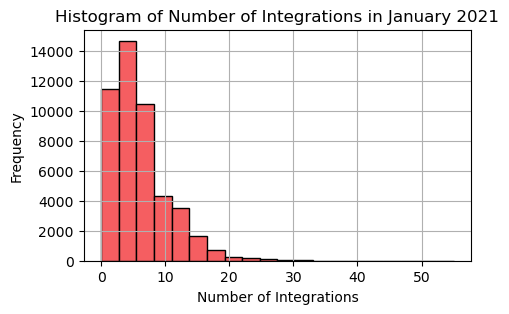

In [17]:

# Plotting the histogram
plt.figure(figsize=(5,3))
plt.hist(jan_df['NUM_OF_INTEGRATIONS'], bins=20, color='#f55e61', edgecolor='black')
plt.title('Histogram of Number of Integrations in January 2021')
plt.xlabel('Number of Integrations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
# Calculate the percentiles
percentiles = customerdf['NUM_OF_INTEGRATIONS'][customerdf['NUM_OF_INTEGRATIONS'] > 0].quantile([0.25, 0.5, 0.75]).tolist()

# Define bin edges
bin_edges = [0, 1, 6, 10, 16, 20, np.inf]

# Define labels for the buckets
bucket_labels = ['0', '1-5', '6-10', '11-15', '16-20', '20+']

# Create the buckets
customerdf['bucket'] = pd.cut(
    customerdf['NUM_OF_INTEGRATIONS'],
    bins=bin_edges,
    labels=bucket_labels,
    right=False,
    include_lowest=True
)

# Check the distribution across the buckets
print(customerdf['bucket'].value_counts())

bucket
1-5      170000
6-10      42163
0         41937
11-15     16194
16-20      2437
20+        1251
Name: count, dtype: int64


In [19]:
customerdf.head(100)

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket
0,H00041533,2020-09,Pro,5,"$1,440.00","$1,440.00",0,1-5
1,H00041533,2020-10,Pro,5,"$1,440.00","$1,480.00",0,1-5
2,H00041533,2020-11,Pro,5,"$1,480.00","$1,480.00",0,1-5
3,H00041533,2021-01,Pro,8,"$1,480.00","$1,560.00",0,6-10
4,H00041533,2020-12,Pro,8,"$1,480.00","$1,480.00",0,6-10
...,...,...,...,...,...,...,...,...
95,H00043306,2020-09,Pro,3,"$1,100.00","$1,100.00",0,1-5
96,H00043306,2020-08,Pro,3,"$1,100.00","$1,100.00",0,1-5
97,H00043488,2020-10,Pro,1,$40.00,$40.00,0,1-5
98,H00043488,2020-11,Pro,1,$40.00,0,-$40.00,1-5


In [20]:
##% # of integrations in Jan 2021
# Total unique customer IDs in Jan 2021
total_unique_customers_2021 = jan_df['CUSTOMER_ID'].nunique()
print(f"Total unique CUSTOMER_IDs in 2021: {total_unique_customers_2021}")

# Unique customer IDs with 0 for NUM_OF_INTEGRATIONS in 2021
unique_customers_zero_integrations_2021 = jan_df[jan_df['NUM_OF_INTEGRATIONS'] == 0]['CUSTOMER_ID'].nunique()
print(f"Unique CUSTOMER_IDs with 0 for NUM_OF_INTEGRATIONS in 2021: {unique_customers_zero_integrations_2021}")

# Calculate the percentage of customers with 0 integrations in 2021
percentage_zero_integrations_2021 = (unique_customers_zero_integrations_2021 / total_unique_customers_2021) * 100
print(f"Percentage of customers with 0 integrations in 2021: {percentage_zero_integrations_2021:.2f}%")

Total unique CUSTOMER_IDs in 2021: 47375
Unique CUSTOMER_IDs with 0 for NUM_OF_INTEGRATIONS in 2021: 2104
Percentage of customers with 0 integrations in 2021: 4.44%


In [21]:
jan_df

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS
3,H00041533,2021-01,Pro,8,"$1,480.00","$1,560.00",0
8,H00041565,2021-01,Basic,4,$600.00,$800.00,0
16,H00041874,2021-01,Pro,1,$680.00,0,-$680.00
20,H00041885,2021-01,Basic,5,$389.34,$389.34,0
27,H00042047,2021-01,Pro,7,$150.00,$150.00,0
...,...,...,...,...,...,...,...
273975,H99945030,2021-01,Starter,1,$50.00,$50.00,0
273976,H99945084,2021-01,Free,2,0,$65.00,0
273978,H99945111,2021-01,Pro,0,$838.00,$838.00,0
273981,H99945164,2021-01,Pro,2,$400.00,$400.00,0


In [22]:
##% # of integrations in 2020-08	

# Filter the DataFrame for SNAPSHOT_MONTH being '2020-08	'
oct_20_df = customerdf[customerdf['SNAPSHOT_MONTH'] == '2020-08']

# Total unique customer IDs in Jan 2021
total_unique_customers_oct_2020 = oct_20_df['CUSTOMER_ID'].nunique()
print(f"Total unique CUSTOMER_IDs in Oct 2020: {total_unique_customers_oct_2020}")

# Unique customer IDs with 0 for NUM_OF_INTEGRATIONS in 2021
unique_customers_zero_integrations_oct_2020 = oct_20_df[oct_20_df['NUM_OF_INTEGRATIONS'] == 0]['CUSTOMER_ID'].nunique()
print(f"Unique CUSTOMER_IDs with 0 for NUM_OF_INTEGRATIONS in 2021: {unique_customers_zero_integrations_oct_2020}")

# Calculate the percentage of customers with 0 integrations in 2021
percentage_zero_integrations_oct_2020 = (unique_customers_zero_integrations_oct_2020 / total_unique_customers_oct_2020) * 100
print(f"Percentage of customers with 0 integrations in Oct 2020: {percentage_zero_integrations_oct_2020:.2f}%")

Total unique CUSTOMER_IDs in Oct 2020: 42896
Unique CUSTOMER_IDs with 0 for NUM_OF_INTEGRATIONS in 2021: 8676
Percentage of customers with 0 integrations in Oct 2020: 20.23%


In [23]:
customerdf.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket
0,H00041533,2020-09,Pro,5,"$1,440.00","$1,440.00",0,1-5
1,H00041533,2020-10,Pro,5,"$1,440.00","$1,480.00",0,1-5
2,H00041533,2020-11,Pro,5,"$1,480.00","$1,480.00",0,1-5
3,H00041533,2021-01,Pro,8,"$1,480.00","$1,560.00",0,6-10
4,H00041533,2020-12,Pro,8,"$1,480.00","$1,480.00",0,6-10


In [24]:
non_numeric_values = customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].apply(lambda x: x if not str(x).replace('.', '', 1).isdigit() else None).dropna()
print(non_numeric_values.unique())

['$1,440.00' '$1,480.00' '$3,060.00' ... '$4,912.00' '$5,039.00'
 '$4,940.00']


In [25]:
#Converting the columns into numeric

# Replace the dollar signs and commas, then convert the column to numeric
customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] = customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].replace('[\$,]', '', regex=True).astype(float)

# Now you can check if the conversion was successful
print(customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].head())

# Replace the dollar signs and commas, then convert the column to numeric
customerdf['CUSTOMER_VALUE_END_OF_MONTH'] = customerdf['CUSTOMER_VALUE_END_OF_MONTH'].replace('[\$,]', '', regex=True).astype(float)

# Now you can check if the conversion was successful
print(customerdf['CUSTOMER_VALUE_END_OF_MONTH'].head())

# Replace the dollar signs and commas, then convert the column to numeric
customerdf['CUSTOMER_CANCELLATION_DOLLARS'] = customerdf['CUSTOMER_CANCELLATION_DOLLARS'].replace('[\$,]', '', regex=True).astype(float)

#check if successfull
print(customerdf['CUSTOMER_CANCELLATION_DOLLARS'].head())

0    1440.0
1    1440.0
2    1480.0
3    1480.0
4    1480.0
Name: CUSTOMER_VALUE_BEGINNING_OF_MONTH, dtype: float64
0    1440.0
1    1480.0
2    1480.0
3    1560.0
4    1480.0
Name: CUSTOMER_VALUE_END_OF_MONTH, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: CUSTOMER_CANCELLATION_DOLLARS, dtype: float64


In [26]:
##Percentage of Customers that have integrations##

# Total unique customer IDs
total_unique_customers = customerdf['CUSTOMER_ID'].nunique()
print(f"Total unique CUSTOMER_IDs: {total_unique_customers}")

# Unique customer IDs with 0 for NUM_OF_INTEGRATIONS
unique_customers_zero_integrations = customerdf[customerdf['NUM_OF_INTEGRATIONS'] == 0]['CUSTOMER_ID'].nunique()
print(f"Unique CUSTOMER_IDs with 0 for NUM_OF_INTEGRATIONS: {unique_customers_zero_integrations}")
print(unique_customers_zero_integrations/total_unique_customers)

Total unique CUSTOMER_IDs: 63882
Unique CUSTOMER_IDs with 0 for NUM_OF_INTEGRATIONS: 20177
0.31584796969412354


In [27]:
# Calculate the C$R column
customerdf['C$R'] = ((customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] - customerdf['CUSTOMER_CANCELLATION_DOLLARS']) / customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'])


In [28]:
customerdf.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R
0,H00041533,2020-09,Pro,5,1440.0,1440.0,0.0,1-5,1.0
1,H00041533,2020-10,Pro,5,1440.0,1480.0,0.0,1-5,1.0
2,H00041533,2020-11,Pro,5,1480.0,1480.0,0.0,1-5,1.0
3,H00041533,2021-01,Pro,8,1480.0,1560.0,0.0,6-10,1.0
4,H00041533,2020-12,Pro,8,1480.0,1480.0,0.0,6-10,1.0


In [29]:
average_integrations_per_customer = customerdf.groupby('CUSTOMER_ID')['NUM_OF_INTEGRATIONS'].mean()
print(average_integrations_per_customer)

CUSTOMER_ID
H00041533    6.000000
H00041565    3.166667
H00041874    1.833333
H00041885    3.333333
H00042047    4.500000
               ...   
H99945030    1.000000
H99945084    2.000000
H99945111    0.000000
H99945164    0.666667
H99945241    0.500000
Name: NUM_OF_INTEGRATIONS, Length: 63882, dtype: float64


In [30]:
# # Check data types of 'CUSTOMER_VALUE_BEGINNING_OF_MONTH' column
# print(jan_df['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].dtype)

# # Replace the dollar signs and commas, then convert the column to numeric
# jan_df['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] = customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].replace('[\$,]', '', regex=True).astype(float)


# # Check for missing or NaN values
# print(jan_df['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].isnull().sum())

# # Group by 'NUM_OF_INTEGRATIONS' and calculate the average 'CUSTOMER_VALUE_BEGINNING_OF_MONTH'
# average_values_jan_21 = jan_df.groupby(jan_df['NUM_OF_INTEGRATIONS'] > 0)['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].mean()

# # Retrieve the averages
# average_value_zero_integrations_jan_21 = average_values_jan_21.loc[False]
# average_value_more_than_zero_integrations_jan_21 = average_values_jan_21.loc[True]

In [31]:
# average_value_more_than_zero_integrations_jan_21

In [32]:
# average_value_zero_integrations_jan_21

In [33]:
# average_value_more_than_zero_integrations_jan21-average_value_zero_integrations_jan_21

In [34]:
numeric_cols = [
    'NUM_OF_INTEGRATIONS', 
    'CUSTOMER_VALUE_BEGINNING_OF_MONTH', 
    'CUSTOMER_CANCELLATION_DOLLARS', 
    'CUSTOMER_VALUE_END_OF_MONTH'
]

for col in numeric_cols:
    customerdf[col] = pd.to_numeric(customerdf[col], errors='coerce')

In [35]:
# Group by 'CUSTOMER_ID' and calculate the average for each numeric column
average_values_per_customer = customerdf.groupby('CUSTOMER_ID').agg({
    'NUM_OF_INTEGRATIONS': 'mean',
    'CUSTOMER_VALUE_BEGINNING_OF_MONTH': 'mean',
    'CUSTOMER_CANCELLATION_DOLLARS': 'mean',
    'CUSTOMER_VALUE_END_OF_MONTH': 'mean'
})

average_values_per_customer

,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,CUSTOMER_VALUE_END_OF_MONTH
CUSTOMER_ID,,,,
H00041533,6.000000,1460.000000,0.000000,1480.000000
H00041565,3.166667,1295.000000,0.000000,918.333333
H00041874,1.833333,680.000000,-113.333333,566.666667
H00041885,3.333333,389.340000,0.000000,389.340000
H00042047,4.500000,116.666667,0.000000,125.000000
...,...,...,...,...
H99945030,1.000000,50.000000,0.000000,50.000000
H99945084,2.000000,0.000000,0.000000,65.000000
H99945111,0.000000,838.000000,0.000000,838.000000


In [36]:
overall_averages = average_values_per_customer.mean()

print("Overall averages across all customers:")
print(overall_averages)

Overall averages across all customers:
NUM_OF_INTEGRATIONS                    2.962926
CUSTOMER_VALUE_BEGINNING_OF_MONTH    694.261431
CUSTOMER_CANCELLATION_DOLLARS        -16.604726
CUSTOMER_VALUE_END_OF_MONTH          720.646977
dtype: float64


In [37]:
# Group by 'NUM_OF_INTEGRATIONS' and calculate mean and sum for the specified columns
grouped_data = customerdf.groupby('NUM_OF_INTEGRATIONS').agg({
    'CUSTOMER_VALUE_BEGINNING_OF_MONTH': ['mean', 'sum'],
    'CUSTOMER_VALUE_END_OF_MONTH': ['mean', 'sum'],
    'CUSTOMER_CANCELLATION_DOLLARS': ['mean', 'sum']
})

print(grouped_data)

                    CUSTOMER_VALUE_BEGINNING_OF_MONTH               \
                                                 mean          sum   
NUM_OF_INTEGRATIONS                                                  
0                                          347.647710  14579302.00   
1                                          518.122748  24300475.00   
2                                          643.097800  27387606.00   
3                                          765.910541  26354981.70   
4                                          900.023241  23545508.00   
5                                         1030.288518  20544983.34   
6                                         1139.986890  17564918.00   
7                                         1248.082226  14283053.00   
8                                         1355.186171  11661377.00   
9                                         1484.383537   9954276.00   
10                                        1577.561011   7550207.00   
11                  

In [38]:
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]
print(grouped_data.reset_index())

    NUM_OF_INTEGRATIONS  CUSTOMER_VALUE_BEGINNING_OF_MONTH_mean  \
0                     0                              347.647710   
1                     1                              518.122748   
2                     2                              643.097800   
3                     3                              765.910541   
4                     4                              900.023241   
5                     5                             1030.288518   
6                     6                             1139.986890   
7                     7                             1248.082226   
8                     8                             1355.186171   
9                     9                             1484.383537   
10                   10                             1577.561011   
11                   11                             1719.751297   
12                   12                             1821.771288   
13                   13                             1863.24316

In [40]:
grouped_data.reset_index(inplace=True)


Coefficients for Beginning of Month Value: Slope = 65.8353, Intercept = 831.6035
Coefficients for End of Month Value: Slope = 66.3177, Intercept = 854.7263
Coefficients for Cancellation Dollars: Slope = 5485.8401, Intercept = -198647.7653


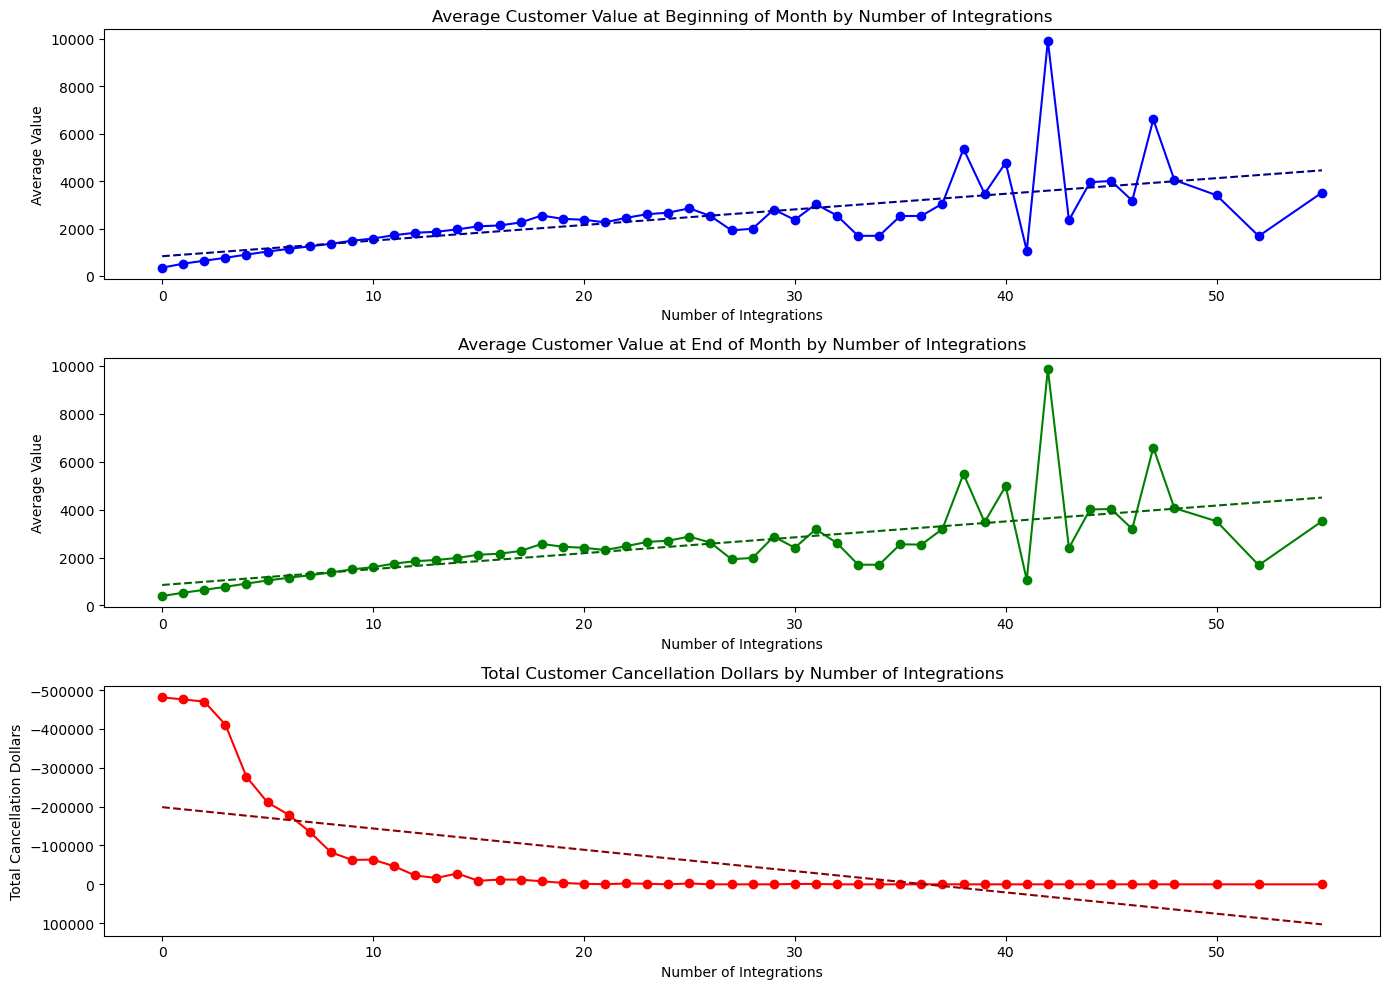

In [41]:
x = grouped_data['NUM_OF_INTEGRATIONS']
y1 = grouped_data['CUSTOMER_VALUE_BEGINNING_OF_MONTH_mean']
y2 = grouped_data['CUSTOMER_VALUE_END_OF_MONTH_mean']
y3 = grouped_data['CUSTOMER_CANCELLATION_DOLLARS_sum']

plt.figure(figsize=(14, 10))

# Function to add a trend line and print coefficients
def add_trend_line_and_print_coefficients(x, y, color, label):
    # Fit a polynomial of degree 1 (linear fit) and return the coefficients
    coefficients = np.polyfit(x, y, 1)
    p = np.poly1d(coefficients)
    plt.plot(x, p(x), linestyle="--", color=color)  # Plotting the trend line
    
    # Printing the coefficients
    print(f"Coefficients for {label}: Slope = {coefficients[0]:.4f}, Intercept = {coefficients[1]:.4f}")

# Plotting Average Beginning of Month Value
plt.subplot(3, 1, 1)
plt.plot(x, y1, marker='o', linestyle='-', color='b')
add_trend_line_and_print_coefficients(x, y1, 'darkblue', 'Beginning of Month Value')
plt.title('Average Customer Value at Beginning of Month by Number of Integrations')
plt.xlabel('Number of Integrations')
plt.ylabel('Average Value')

# Plotting Average End of Month Value
plt.subplot(3, 1, 2)
plt.plot(x, y2, marker='o', linestyle='-', color='g')
add_trend_line_and_print_coefficients(x, y2, 'darkgreen', 'End of Month Value')
plt.title('Average Customer Value at End of Month by Number of Integrations')
plt.xlabel('Number of Integrations')
plt.ylabel('Average Value')

# Plotting Sum of Cancellation Dollars
plt.subplot(3, 1, 3)
plt.plot(x, y3, marker='o', linestyle='-', color='r')
add_trend_line_and_print_coefficients(x, y3, 'darkred', 'Cancellation Dollars')
plt.title('Total Customer Cancellation Dollars by Number of Integrations')
plt.xlabel('Number of Integrations')
plt.ylabel('Total Cancellation Dollars')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

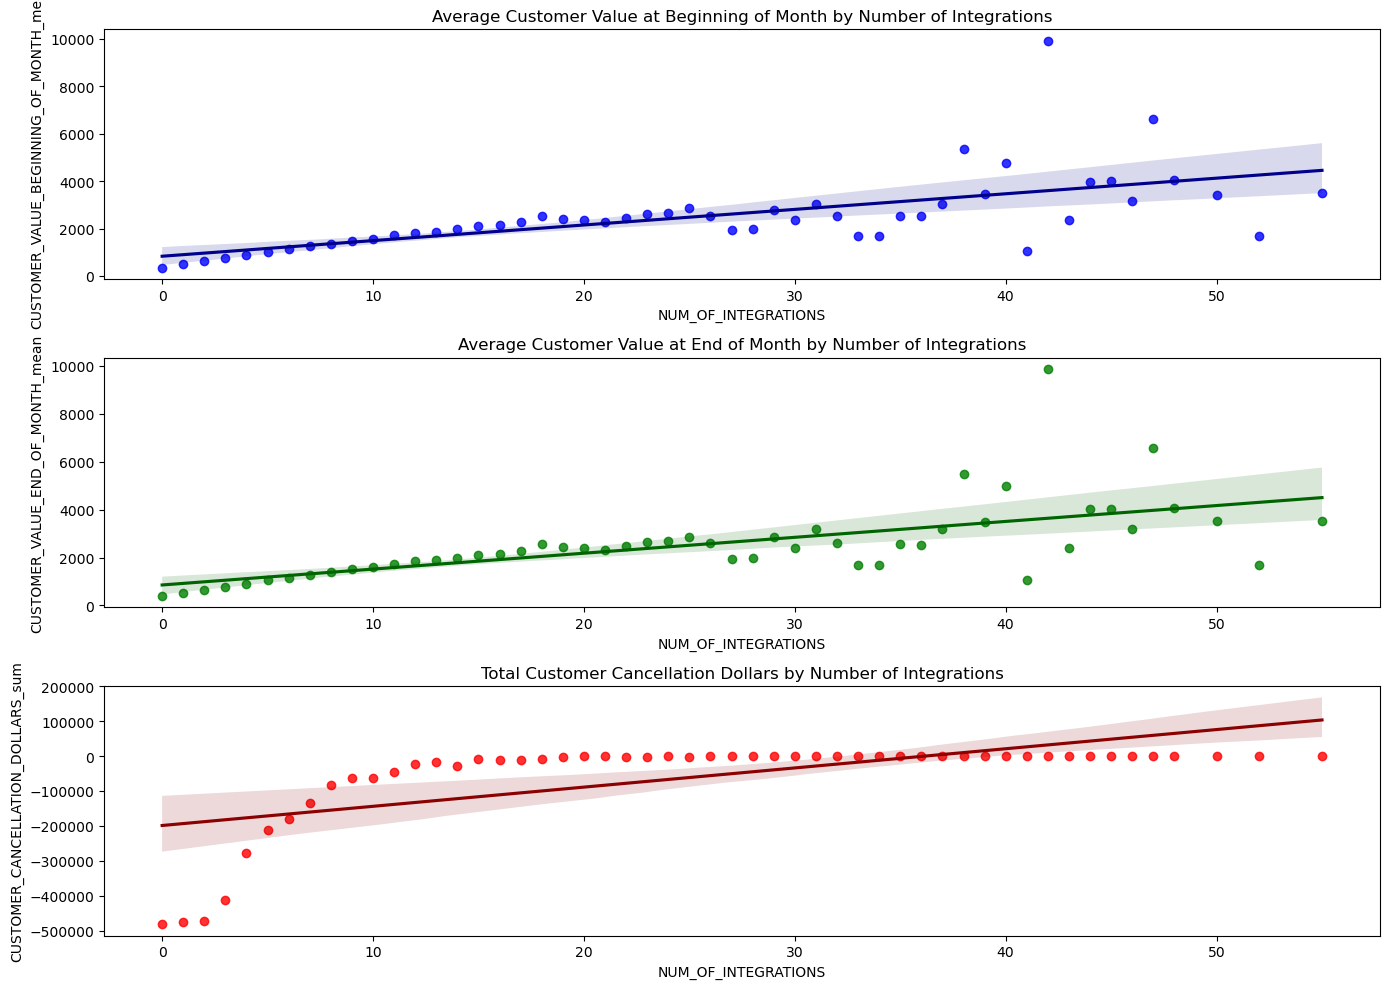

In [42]:
plt.figure(figsize=(14, 10))

# Plotting with regression lines
plt.subplot(3, 1, 1)
sns.regplot(x='NUM_OF_INTEGRATIONS', y='CUSTOMER_VALUE_BEGINNING_OF_MONTH_mean', data=grouped_data, marker='o', color='b', line_kws={"color": "darkblue"})
plt.title('Average Customer Value at Beginning of Month by Number of Integrations')

plt.subplot(3, 1, 2)
sns.regplot(x='NUM_OF_INTEGRATIONS', y='CUSTOMER_VALUE_END_OF_MONTH_mean', data=grouped_data, marker='o', color='g', line_kws={"color": "darkgreen"})
plt.title('Average Customer Value at End of Month by Number of Integrations')

plt.subplot(3, 1, 3)
sns.regplot(x='NUM_OF_INTEGRATIONS', y='CUSTOMER_CANCELLATION_DOLLARS_sum', data=grouped_data, marker='o', color='r', line_kws={"color": "darkred"})
plt.title('Total Customer Cancellation Dollars by Number of Integrations')

plt.tight_layout()
plt.show()

#Monthly Integrations Average


In [43]:
# Convert 'SNAPSHOT_MONTH' to datetime format
customerdf['SNAPSHOT_MONTH'] = pd.to_datetime(customerdf['SNAPSHOT_MONTH'])

# Sort the DataFrame by 'SNAPSHOT_MONTH'
customerdf.sort_values('SNAPSHOT_MONTH', inplace=True)

# Group by 'SNAPSHOT_MONTH' and calculate the mean of 'NUM_OF_INTEGRATIONS'
monthly_avg_integrations = customerdf.groupby(customerdf['SNAPSHOT_MONTH'].dt.to_period('M'))['NUM_OF_INTEGRATIONS'].mean()

# Calculate the month-over-month change in average number of integrations
monthly_avg_integrations_change = monthly_avg_integrations.diff().fillna(0)

# Show the results
print(monthly_avg_integrations_change)
print(monthly_avg_integrations)

SNAPSHOT_MONTH
2020-08    0.000000
2020-09    0.088560
2020-10    0.067843
2020-11    0.298094
2020-12    0.470781
2021-01    2.065099
Freq: M, Name: NUM_OF_INTEGRATIONS, dtype: float64
SNAPSHOT_MONTH
2020-08    2.868473
2020-09    2.957032
2020-10    3.024875
2020-11    3.322970
2020-12    3.793751
2021-01    5.858850
Freq: M, Name: NUM_OF_INTEGRATIONS, dtype: float64


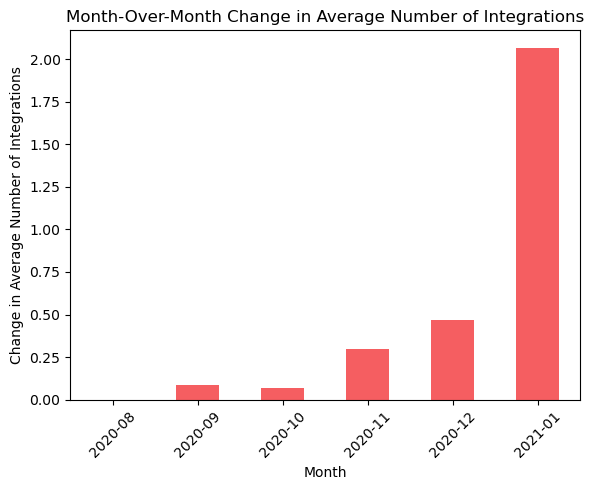

In [44]:
# Ensure 'SNAPSHOT_MONTH' is in datetime format
customerdf['SNAPSHOT_MONTH'] = pd.to_datetime(customerdf['SNAPSHOT_MONTH'])

# Sort DataFrame by 'SNAPSHOT_MONTH'
customerdf.sort_values('SNAPSHOT_MONTH', inplace=True)

# Group by 'SNAPSHOT_MONTH' and calculate the average 'NUM_OF_INTEGRATIONS' for each month
monthly_avg_integrations = customerdf.groupby(customerdf['SNAPSHOT_MONTH'].dt.to_period('M'))['NUM_OF_INTEGRATIONS'].mean()

# Calculate the month-over-month difference in average number of integrations
monthly_avg_integrations_diff = monthly_avg_integrations.diff().fillna(0)

# Create a bar chart for the month-over-month change in average number of integrations
plt.figure(figsize=(6, 5))
monthly_avg_integrations_diff.plot(kind='bar', color='#f55e61')
plt.title('Month-Over-Month Change in Average Number of Integrations')
plt.xlabel('Month')
plt.ylabel('Change in Average Number of Integrations')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Diving into the intergrations themselves

In [45]:
# Locate rows where 'INTEGRATION_ID' starts with 'CUSTOM'
mask = integrationsdf['INTEGRATION_ID'].str.startswith('CUSTOM')

# Replace values in 'INTEGRATION_ID' with 'CUSTOM' where the condition is met
integrationsdf.loc[mask, 'INTEGRATION_ID'] = 'CUSTOM'

In [46]:
# # Count the occurrences of each 'integration_id'
# integration_counts = integrationsdf['INTEGRATION_ID'].value_counts()

# # Create a bar chart distribution of 'integration_id'
# plt.figure(figsize=(12, 6))
# integration_counts.plot(kind='bar', color='#f55e61')
# plt.title('Distribution of Integration IDs')
# plt.xlabel('Integration ID')
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)  # Rotate the x-axis labels for readability if there are many unique IDs
# plt.tight_layout()
# plt.show()


In [47]:
## Convert 'SNAPSHOT_MONTH' to datetime format (if not already done)
customerdf['SNAPSHOT_MONTH'] = pd.to_datetime(customerdf['SNAPSHOT_MONTH'])

# Group by 'PRODUCT_TIER' and 'SNAPSHOT_MONTH' and calculate the average 'NUM_OF_INTEGRATIONS' for each product tier and month
avg_integrations_per_product_tier_per_month = customerdf.groupby(['PRODUCT_TIER', customerdf['SNAPSHOT_MONTH'].dt.to_period('M')])['NUM_OF_INTEGRATIONS'].mean()

# Display the result
print(avg_integrations_per_product_tier_per_month)

PRODUCT_TIER  SNAPSHOT_MONTH
Basic         2020-08           1.360489
              2020-09           1.450990
              2020-10           1.485701
              2020-11           1.743848
              2020-12           2.080658
              2021-01           4.014252
Enterprise    2020-08           5.142557
              2020-09           5.236018
              2020-10           5.486425
              2020-11           5.951059
              2020-12           6.647847
              2021-01           9.597116
Free          2020-08           1.089483
              2020-09           1.101112
              2020-10           1.278867
              2020-11           1.442789
              2020-12           1.543787
              2021-01           2.177043
Pro           2020-08           3.037804
              2020-09           3.131032
              2020-10           3.244984
              2020-11           3.527707
              2020-12           4.007121
              2021-01       

In [48]:
# Group by 'PRODUCT_TIER' and 'SNAPSHOT_MONTH' and calculate the average 'NUM_OF_INTEGRATIONS' for each product tier and month
avg_integrations_per_product_tier_per_month = customerdf.groupby(['PRODUCT_TIER', customerdf['SNAPSHOT_MONTH'].dt.to_period('M')])['NUM_OF_INTEGRATIONS'].mean()

# Convert the grouped data into a pivot table
pivot_table_avg_integrations = avg_integrations_per_product_tier_per_month.reset_index().pivot_table(index='SNAPSHOT_MONTH', columns='PRODUCT_TIER', values='NUM_OF_INTEGRATIONS')

# Display the pivot table
print(pivot_table_avg_integrations)

PRODUCT_TIER       Basic  Enterprise      Free       Pro   Starter
SNAPSHOT_MONTH                                                    
2020-08         1.360489    5.142557  1.089483  3.037804  1.351944
2020-09         1.450990    5.236018  1.101112  3.131032  1.469285
2020-10         1.485701    5.486425  1.278867  3.244984  1.444728
2020-11         1.743848    5.951059  1.442789  3.527707  1.555183
2020-12         2.080658    6.647847  1.543787  4.007121  1.905927
2021-01         4.014252    9.597116  2.177043  6.278120  2.759749


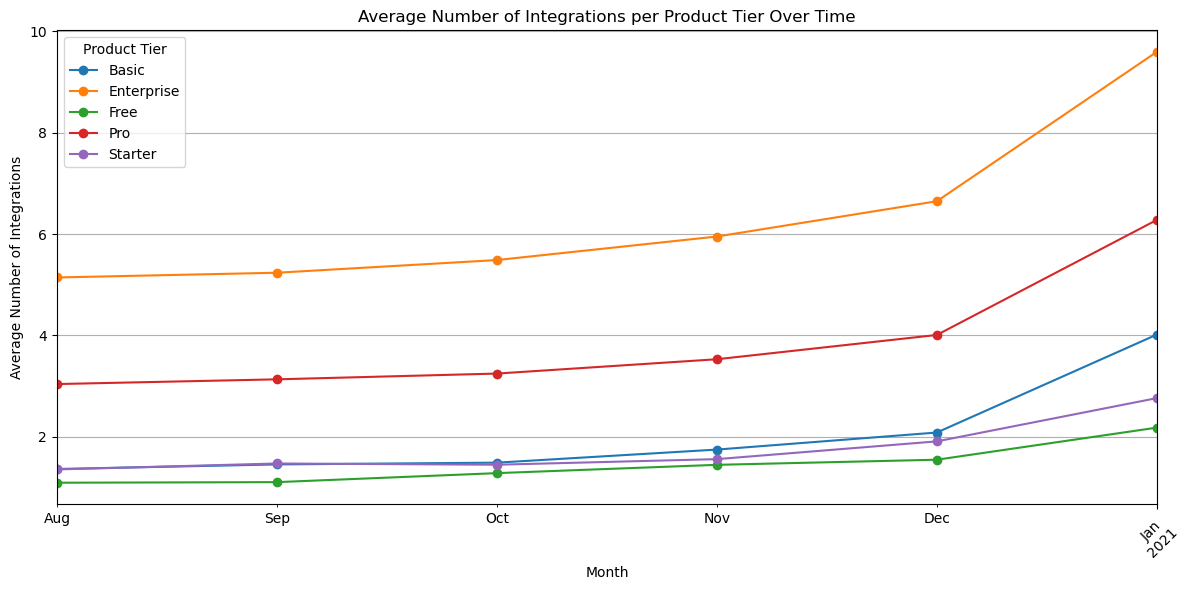

In [49]:
# Plotting the line chart
pivot_table_avg_integrations.plot(kind='line', marker='o', figsize=(12, 6))

# Adding labels and title
plt.title('Average Number of Integrations per Product Tier Over Time')
plt.xlabel('Month')
plt.ylabel('Average Number of Integrations')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.legend(title='Product Tier')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:

# Convert columns to numeric, coerce any errors into NaNs
customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] = pd.to_numeric(customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'], errors='coerce')
customerdf['CUSTOMER_CANCELLATION_DOLLARS'] = pd.to_numeric(customerdf['CUSTOMER_CANCELLATION_DOLLARS'], errors='coerce')
customerdf = customerdf[customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] != 0]


# Check for any rows where CUSTOMER_VALUE_BEGINNING_OF_MONTH is zero, as this will cause division by zero errors
if (customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] == 0).any():
    print("Warning: There are rows with a 'CUSTOMER_VALUE_BEGINNING_OF_MONTH' of 0, which will result in division by zero.")
    # Handle these cases as needed, perhaps by setting them to NaN or some sentinel value

# Calculate the C$R column, avoiding division by zero
customerdf['C$R'] = (customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH'] + customerdf['CUSTOMER_CANCELLATION_DOLLARS']) / customerdf['CUSTOMER_VALUE_BEGINNING_OF_MONTH']

customerdf.head(100)

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R
136992,H49943112,2020-08-01,Basic,0,520.0,520.0,0.0,0,1.0
16737,H05941810,2020-08-01,Pro,7,1250.0,1300.0,0.0,6-10,1.0
229549,H83742451,2020-08-01,Pro,4,154.0,154.0,0.0,1-5,1.0
16720,H05941652,2020-08-01,Pro,4,50.0,50.0,0.0,1-5,1.0
16719,H05941535,2020-08-01,Pro,1,720.0,720.0,0.0,1-5,1.0
...,...,...,...,...,...,...,...,...,...
224968,H82142515,2020-08-01,Basic,1,200.0,200.0,0.0,1-5,1.0
258235,H94243930,2020-08-01,Pro,3,268.0,333.0,0.0,1-5,1.0
258186,H94242838,2020-08-01,Pro,0,40.0,40.0,0.0,0,1.0
258134,H94242348,2020-08-01,Enterprise,2,1699.0,1699.0,0.0,1-5,1.0


In [51]:
average_csr = customerdf['C$R'].mean()

print(f"The average C$R is: {average_csr}")

The average C$R is: 0.9728033866199418


In [52]:
average_cancel = customerdf['CUSTOMER_CANCELLATION_DOLLARS'].mean()

print(f"The average cancel $ is: {average_cancel}")

The average cancel $ is: -11.513470917319859


In [53]:
# Filter the DataFrame where 'C$R' is greater than 1
filtered_df = customerdf[customerdf['C$R'] <= 1]

# Display the filtered DataFrame
filtered_df.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R
136992,H49943112,2020-08-01,Basic,0,520.0,520.0,0.0,0,1.0
16737,H05941810,2020-08-01,Pro,7,1250.0,1300.0,0.0,6-10,1.0
229549,H83742451,2020-08-01,Pro,4,154.0,154.0,0.0,1-5,1.0
16720,H05941652,2020-08-01,Pro,4,50.0,50.0,0.0,1-5,1.0
16719,H05941535,2020-08-01,Pro,1,720.0,720.0,0.0,1-5,1.0


# Combining Data Sets

In [54]:
customer_and_accounts_df = pd.merge(customerdf, accountsdf, how='left', on=['CUSTOMER_ID'])
customer_and_accounts_df['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].fillna(0, inplace=True)
customer_and_accounts_df.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R,EMPLOYEE_SIZE,CUSTOMER_SEGMENT
0,H49943112,2020-08-01,Basic,0,520.0,520.0,0.0,0,1.0,26 to 200,International Low-touch
1,H05941810,2020-08-01,Pro,7,1250.0,1300.0,0.0,6-10,1.0,1 to 25,NAM Partner
2,H83742451,2020-08-01,Pro,4,154.0,154.0,0.0,1-5,1.0,1 to 25,International Low-touch
3,H05941652,2020-08-01,Pro,4,50.0,50.0,0.0,1-5,1.0,201 or Above,NAM Low-Touch
4,H05941535,2020-08-01,Pro,1,720.0,720.0,0.0,1-5,1.0,1 to 25,International Direct


# Regression

In [55]:
# Drop directly correlated column
customer_and_accounts_df = customer_and_accounts_df.drop('CUSTOMER_VALUE_BEGINNING_OF_MONTH', axis=1)
##Drop uneeded
customer_and_accounts_df = customer_and_accounts_df.drop('CUSTOMER_ID', axis=1)

# Create dummy variables for categorical features
customer_and_accounts_df = pd.get_dummies(customer_and_accounts_df, columns=['EMPLOYEE_SIZE', 'CUSTOMER_SEGMENT', 'PRODUCT_TIER', 'SNAPSHOT_MONTH'], drop_first=True)


# Check for any remaining non-numeric columns that might need handling
print(customer_and_accounts_df.dtypes)


NUM_OF_INTEGRATIONS                             int64
CUSTOMER_VALUE_END_OF_MONTH                   float64
CUSTOMER_CANCELLATION_DOLLARS                 float64
bucket                                       category
C$R                                           float64
EMPLOYEE_SIZE_201 or Above                       bool
EMPLOYEE_SIZE_26 to 200                          bool
EMPLOYEE_SIZE_Undefined                          bool
CUSTOMER_SEGMENT_International High-touch        bool
CUSTOMER_SEGMENT_International Low-touch         bool
CUSTOMER_SEGMENT_International Partner           bool
CUSTOMER_SEGMENT_NAM Direct                      bool
CUSTOMER_SEGMENT_NAM High-touch                  bool
CUSTOMER_SEGMENT_NAM Low-Touch                   bool
CUSTOMER_SEGMENT_NAM Partner                     bool
CUSTOMER_SEGMENT_NAM Unowned                     bool
PRODUCT_TIER_Enterprise                          bool
PRODUCT_TIER_Pro                                 bool
PRODUCT_TIER_Starter        

In [56]:
# Drop the target variable from the predictors DataFrame
X = customer_and_accounts_df.drop(['CUSTOMER_VALUE_END_OF_MONTH', 'bucket'], axis=1)
y = customer_and_accounts_df['CUSTOMER_VALUE_END_OF_MONTH']

# Convert boolean columns to integers
boolean_columns = X.select_dtypes(include=['bool']).columns
X[boolean_columns] = X[boolean_columns].astype(int)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the summary of the regression
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     CUSTOMER_VALUE_END_OF_MONTH   R-squared:                       0.566
Model:                                     OLS   Adj. R-squared:                  0.566
Method:                          Least Squares   F-statistic:                 1.556e+04
Date:                         Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                                 11:04:15   Log-Likelihood:            -2.0865e+06
No. Observations:                       262046   AIC:                         4.173e+06
Df Residuals:                           262023   BIC:                         4.173e+06
Df Model:                                   22                                         
Covariance Type:                     nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF factors. We skip the first column which is the constant term.
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns[1:]  # skipping the constant
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]

print(vif_data)

                                      feature       VIF
0                         NUM_OF_INTEGRATIONS  1.314346
1               CUSTOMER_CANCELLATION_DOLLARS  1.336044
2                                         C$R  1.355652
3                  EMPLOYEE_SIZE_201 or Above  1.222512
4                     EMPLOYEE_SIZE_26 to 200  1.205164
5                     EMPLOYEE_SIZE_Undefined  1.072269
6   CUSTOMER_SEGMENT_International High-touch  1.032791
7    CUSTOMER_SEGMENT_International Low-touch  1.620960
8      CUSTOMER_SEGMENT_International Partner  1.330988
9                 CUSTOMER_SEGMENT_NAM Direct  1.750201
10            CUSTOMER_SEGMENT_NAM High-touch  1.399951
11             CUSTOMER_SEGMENT_NAM Low-Touch  2.201438
12               CUSTOMER_SEGMENT_NAM Partner  1.406898
13               CUSTOMER_SEGMENT_NAM Unowned  1.017745
14                    PRODUCT_TIER_Enterprise  2.821825
15                           PRODUCT_TIER_Pro  3.168432
16                       PRODUCT_TIER_Starter  2

In [58]:
# Drop the target variable from the predictors DataFrame
X = customer_and_accounts_df.drop(['C$R', 'bucket'], axis=1)
y = customer_and_accounts_df['C$R']

# Convert boolean columns to integers
boolean_columns = X.select_dtypes(include=['bool']).columns
X[boolean_columns] = X[boolean_columns].astype(int)

# Check for NaNs or infinite values in X and y
print("NaNs in X:", X.isnull().any().any())
print("NaNs in y:", y.isnull().any())
print("Infs in X:", np.isinf(X).any().any())
print("Infs in y:", np.isinf(y).any())

# Drop rows with NaNs or replace them
X = X.dropna()  # or X.fillna(method_of_imputation)
y = y.dropna()  # or y.fillna(method_of_imputation)
# Ensure y is aligned with X after dropping rows
y = y[X.index]

# Replace infinite values if they exist
X.replace([np.inf, -np.inf], np.nan, inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)

# Additional dropna in case infinite values were replaced with NaNs
X.dropna(inplace=True)
y = y[X.index]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the summary of the regression
print(model.summary())


NaNs in X: False
NaNs in y: False
Infs in X: False
Infs in y: False
                            OLS Regression Results                            
Dep. Variable:                    C$R   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     4279.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:04:26   Log-Likelihood:             1.4925e+05
No. Observations:              262046   AIC:                        -2.985e+05
Df Residuals:                  262023   BIC:                        -2.982e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [59]:
customerdf['SNAPSHOT_MONTH'] = pd.to_datetime(customerdf['SNAPSHOT_MONTH'])
# Goup by 'SNAPSHOT_MONTH' and 'bucket' and calculate the mean of 'C$R'
monthly_avg_csr = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['C$R'].mean().reset_index()

# Pivot the data 
pivot_monthly_avg_csr = monthly_avg_csr.pivot(index='SNAPSHOT_MONTH', columns='bucket', values='C$R')

print(pivot_monthly_avg_csr)

bucket                 0       1-5      6-10     11-15     16-20       20+
SNAPSHOT_MONTH                                                            
2020-08-01      0.951395  0.983484  0.992111  0.989746  1.000000  0.998296
2020-09-01      0.952556  0.979923  0.987653  0.990528  1.000000  0.998445
2020-10-01      0.943872  0.974789  0.985630  0.987376  0.994754  0.977675
2020-11-01      0.946711  0.973121  0.987269  0.990734  0.982616  0.986571
2020-12-01      0.944611  0.970562  0.983607  0.987264  0.990148  0.994504
2021-01-01      0.902829  0.955602  0.983780  0.991919  0.994253  0.995482


/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_50901/1134687360.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_csr = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['C$R'].mean().reset_index()


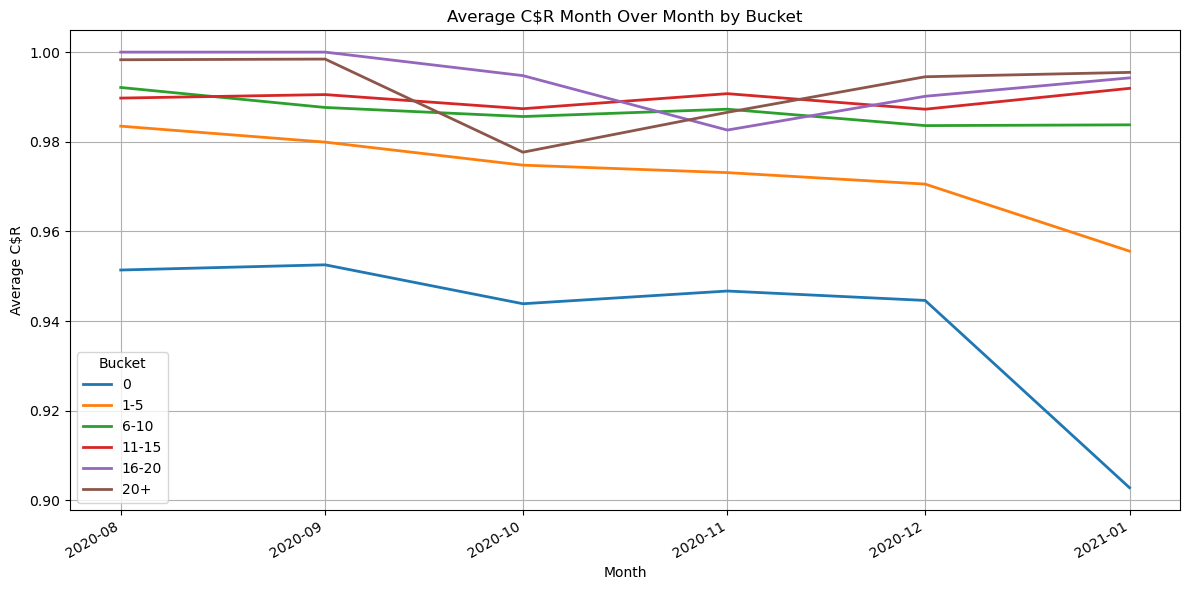

In [60]:


# Plotting
plt.figure(figsize=(12, 6))

for column in pivot_monthly_avg_csr.columns:
    plt.plot(pivot_monthly_avg_csr.index, pivot_monthly_avg_csr[column], marker='', linewidth=2, label=column)

# Set x-axis major locator and formatter to format dates nicely
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Improve spacing and aesthetics
plt.gcf().autofmt_xdate() # Rotation
plt.title('Average C$R Month Over Month by Bucket')
plt.xlabel('Month')
plt.ylabel('Average C$R')
plt.grid(True)
plt.legend(title='Bucket')
plt.tight_layout()

# Show plot
plt.show()

In [61]:
customer_and_accounts_df

,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R,EMPLOYEE_SIZE_201 or Above,EMPLOYEE_SIZE_26 to 200,EMPLOYEE_SIZE_Undefined,CUSTOMER_SEGMENT_International High-touch,CUSTOMER_SEGMENT_International Low-touch,...,CUSTOMER_SEGMENT_NAM Partner,CUSTOMER_SEGMENT_NAM Unowned,PRODUCT_TIER_Enterprise,PRODUCT_TIER_Pro,PRODUCT_TIER_Starter,SNAPSHOT_MONTH_2020-09-01 00:00:00,SNAPSHOT_MONTH_2020-10-01 00:00:00,SNAPSHOT_MONTH_2020-11-01 00:00:00,SNAPSHOT_MONTH_2020-12-01 00:00:00,SNAPSHOT_MONTH_2021-01-01 00:00:00
0,0,520.0,0.0,0,1.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,7,1300.0,0.0,6-10,1.0,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
2,4,154.0,0.0,1-5,1.0,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,4,50.0,0.0,1-5,1.0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,1,720.0,0.0,1-5,1.0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262041,11,3006.0,0.0,11-15,1.0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
262042,5,987.0,0.0,1-5,1.0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
262043,0,50.0,0.0,0,1.0,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
262044,10,3561.0,0.0,11-15,1.0,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [62]:
# Drop the target variable from the predictors DataFrame
X = customer_and_accounts_df.drop(['C$R', 'bucket'], axis=1)
y = customer_and_accounts_df['C$R']

# Convert boolean columns to integers
boolean_columns = X.select_dtypes(include=['bool']).columns
X[boolean_columns] = X[boolean_columns].astype(int)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    C$R   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     4279.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:04:26   Log-Likelihood:             1.4925e+05
No. Observations:              262046   AIC:                        -2.985e+05
Df Residuals:                  262023   BIC:                        -2.982e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Display the VIF values
print(vif_data)

                                      feature        VIF
0                                       const  24.041238
1                         NUM_OF_INTEGRATIONS   1.395507
2                 CUSTOMER_VALUE_END_OF_MONTH   2.299929
3               CUSTOMER_CANCELLATION_DOLLARS   1.019335
4                  EMPLOYEE_SIZE_201 or Above   1.266000
5                     EMPLOYEE_SIZE_26 to 200   1.235461
6                     EMPLOYEE_SIZE_Undefined   1.072179
7   CUSTOMER_SEGMENT_International High-touch   1.048347
8    CUSTOMER_SEGMENT_International Low-touch   1.664068
9      CUSTOMER_SEGMENT_International Partner   1.330924
10                CUSTOMER_SEGMENT_NAM Direct   1.751734
11            CUSTOMER_SEGMENT_NAM High-touch   1.400051
12             CUSTOMER_SEGMENT_NAM Low-Touch   2.288691
13               CUSTOMER_SEGMENT_NAM Partner   1.415749
14               CUSTOMER_SEGMENT_NAM Unowned   1.016620
15                    PRODUCT_TIER_Enterprise   3.457583
16                           PR

In [64]:
# Group by 'SNAPSHOT_MONTH' and 'bucket' and calculate the mean of 'Cancel_dollars'
monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['CUSTOMER_CANCELLATION_DOLLARS'].mean().reset_index()

# Pivot the data to have months as the rows and buckets as the columns
pivot_monthly_avg_cancel_dollars = monthly_avg_cancel_dollars.pivot(index='SNAPSHOT_MONTH', columns='bucket', values='CUSTOMER_CANCELLATION_DOLLARS')

# Print the pivoted DataFrame to see the monthly average cancel dollars by bucket
print(pivot_monthly_avg_cancel_dollars)

bucket                  0        1-5       6-10      11-15      16-20  \
SNAPSHOT_MONTH                                                          
2020-08-01     -12.106253  -7.461320  -6.780208 -22.370725   0.000000   
2020-09-01     -12.239735  -9.068179 -10.982538 -15.012912   0.000000   
2020-10-01     -11.505189 -10.194414 -11.141265 -13.554850 -15.816239   
2020-11-01     -13.415533 -11.068243  -9.950008  -7.588862 -27.764085   
2020-12-01     -13.450926 -14.543794 -14.645287 -14.198308 -15.218673   
2021-01-01     -25.916096 -15.887881 -10.805831  -7.976624 -15.729494   

bucket                20+  
SNAPSHOT_MONTH             
2020-08-01      -4.347826  
2020-09-01      -3.047619  
2020-10-01     -21.903226  
2020-11-01      -3.548387  
2020-12-01     -14.937198  
2021-01-01      -4.429329  


/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_50901/412778882.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['CUSTOMER_CANCELLATION_DOLLARS'].mean().reset_index()


/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_50901/1274043045.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['CUSTOMER_CANCELLATION_DOLLARS'].mean().reset_index()


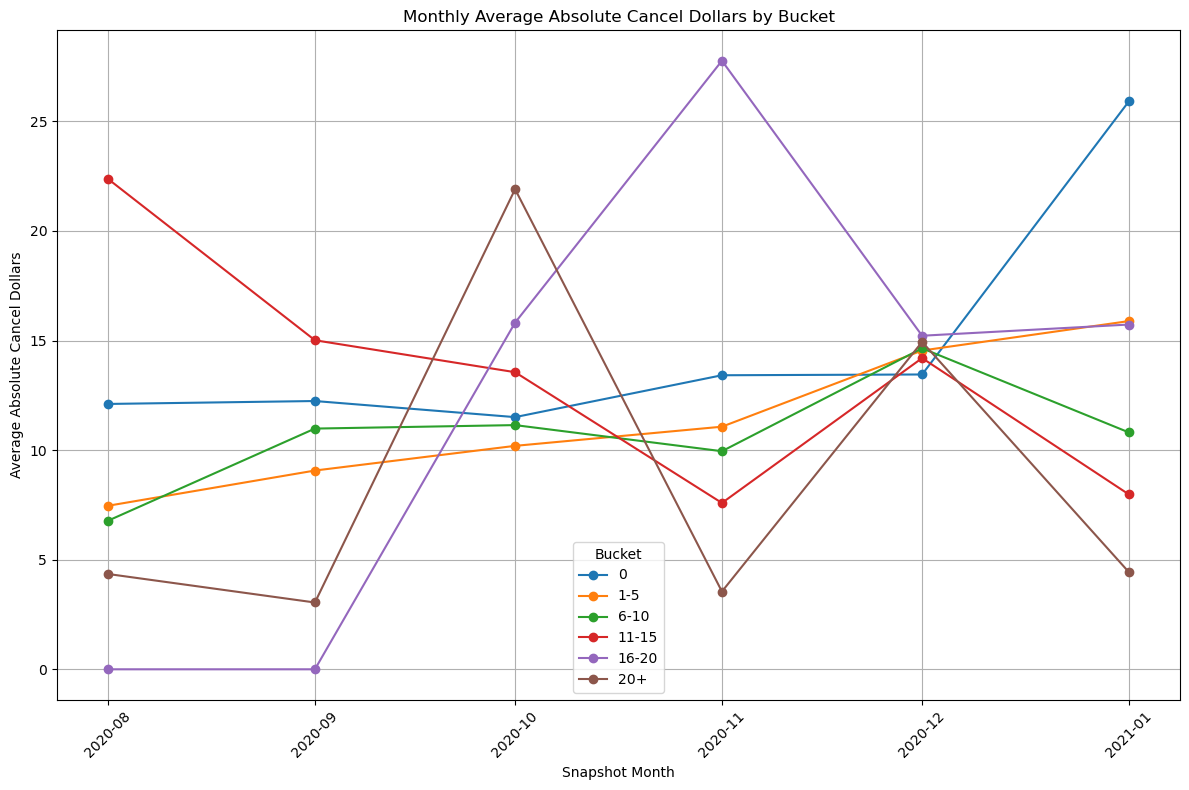

In [65]:
# Take the absolute value of the 'CUSTOMER_CANCELLATION_DOLLARS' column
customerdf['CUSTOMER_CANCELLATION_DOLLARS'] = customerdf['CUSTOMER_CANCELLATION_DOLLARS'].abs()

# Group by 'SNAPSHOT_MONTH' and 'bucket' and calculate the mean of the absolute 'CUSTOMER_CANCELLATION_DOLLARS'
monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['CUSTOMER_CANCELLATION_DOLLARS'].mean().reset_index()

# Pivot the data to have months as the rows and buckets as the columns
pivot_monthly_avg_cancel_dollars = monthly_avg_cancel_dollars.pivot(index='SNAPSHOT_MONTH', columns='bucket', values='CUSTOMER_CANCELLATION_DOLLARS')

# Plotting
plt.figure(figsize=(12, 8))

# Plot each bucket as a separate line on the chart
for column in pivot_monthly_avg_cancel_dollars.columns:
    plt.plot(pivot_monthly_avg_cancel_dollars.index, pivot_monthly_avg_cancel_dollars[column], marker='o', linestyle='-', label=column)

plt.title('Monthly Average Absolute Cancel Dollars by Bucket')
plt.xlabel('Snapshot Month')
plt.ylabel('Average Absolute Cancel Dollars')
plt.legend(title='Bucket')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()  # Adjust layout to prevent overlapping labels

plt.show()

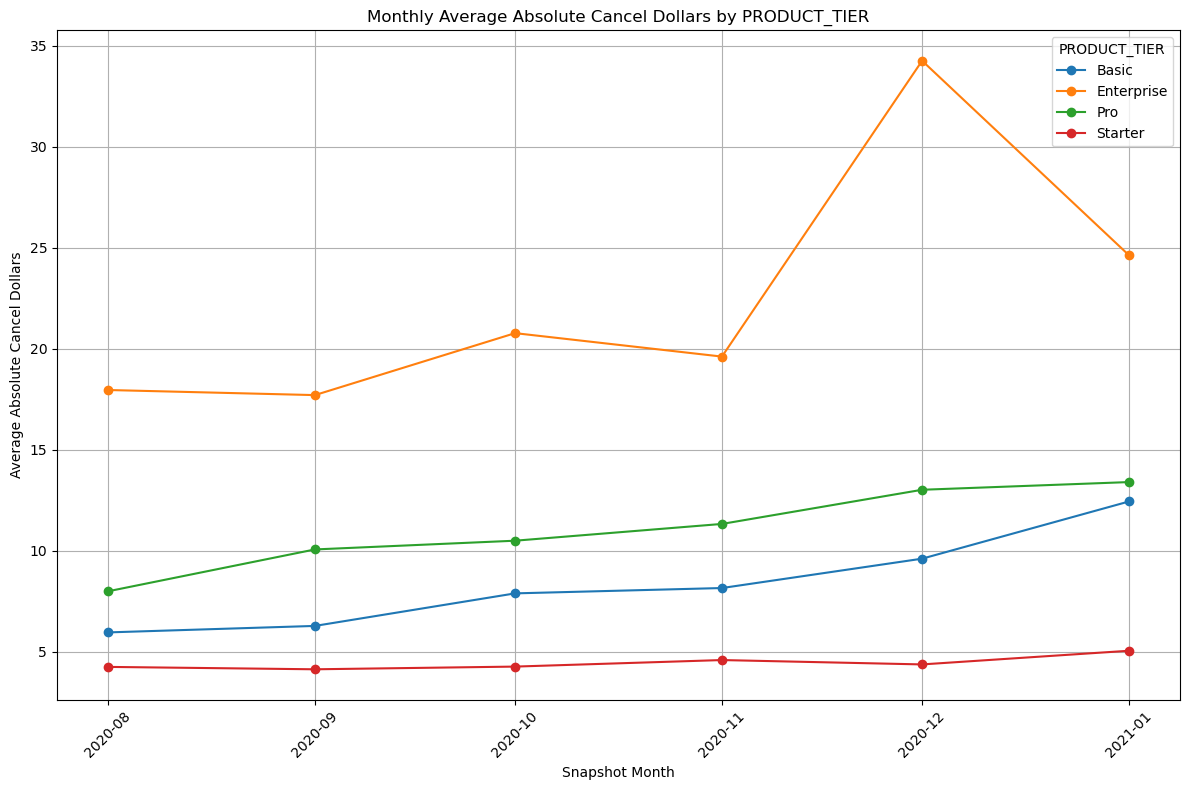

In [66]:
# Take the absolute value of the 'CUSTOMER_CANCELLATION_DOLLARS' column
customerdf['CUSTOMER_CANCELLATION_DOLLARS'] = customerdf['CUSTOMER_CANCELLATION_DOLLARS']

# Group by 'SNAPSHOT_MONTH' and 'bucket' and calculate the mean of the absolute 'CUSTOMER_CANCELLATION_DOLLARS'
monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'PRODUCT_TIER'])['CUSTOMER_CANCELLATION_DOLLARS'].mean().reset_index()

# Pivot the data to have months as the rows and buckets as the columns
pivot_monthly_avg_cancel_dollars = monthly_avg_cancel_dollars.pivot(index='SNAPSHOT_MONTH', columns='PRODUCT_TIER', values='CUSTOMER_CANCELLATION_DOLLARS')

# Plotting
plt.figure(figsize=(12, 8))

# Plot each bucket as a separate line on the chart
for column in pivot_monthly_avg_cancel_dollars.columns:
    plt.plot(pivot_monthly_avg_cancel_dollars.index, pivot_monthly_avg_cancel_dollars[column], marker='o', linestyle='-', label=column)

plt.title('Monthly Average Absolute Cancel Dollars by PRODUCT_TIER')
plt.xlabel('Snapshot Month')
plt.ylabel('Average Absolute Cancel Dollars')
plt.legend(title='PRODUCT_TIER')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()  # Adjust layout to prevent overlapping labels

plt.show()

In [67]:

# # Group by 'SNAPSHOT_MONTH' and 'bucket' and calculate the mean of the absolute 'CUSTOMER_CANCELLATION_DOLLARS'
# monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'PRODUCT_TIER'])['CUSTOMER_VALUE_END_OF_MONTH'].mean().reset_index()

# # Pivot the data to have months as the rows and buckets as the columns
# pivot_monthly_avg_cancel_dollars = monthly_avg_cancel_dollars.pivot(index='SNAPSHOT_MONTH', columns='PRODUCT_TIER', values='CUSTOMER_VALUE_END_OF_MONTH')

# # Plotting
# plt.figure(figsize=(12, 8))

# # Plot each bucket as a separate line on the chart
# for column in pivot_monthly_avg_cancel_dollars.columns:
#     plt.plot(pivot_monthly_avg_cancel_dollars.index, pivot_monthly_avg_cancel_dollars[column], marker='o', linestyle='-', label=column)

# plt.title('Monthly Average Absolute CUSTOMER_VALUE_END_OF_MONTH by PRODUCT_TIER')
# plt.xlabel('Snapshot Month')
# plt.ylabel('Average CUSTOMER_VALUE_END_OF_MONTH')
# plt.legend(title='PRODUCT_TIER')
# plt.grid(True)
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
# plt.tight_layout()  # Adjust layout to prevent overlapping labels

# plt.show()

/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_50901/4184994142.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['CUSTOMER_VALUE_END_OF_MONTH'].mean().reset_index()


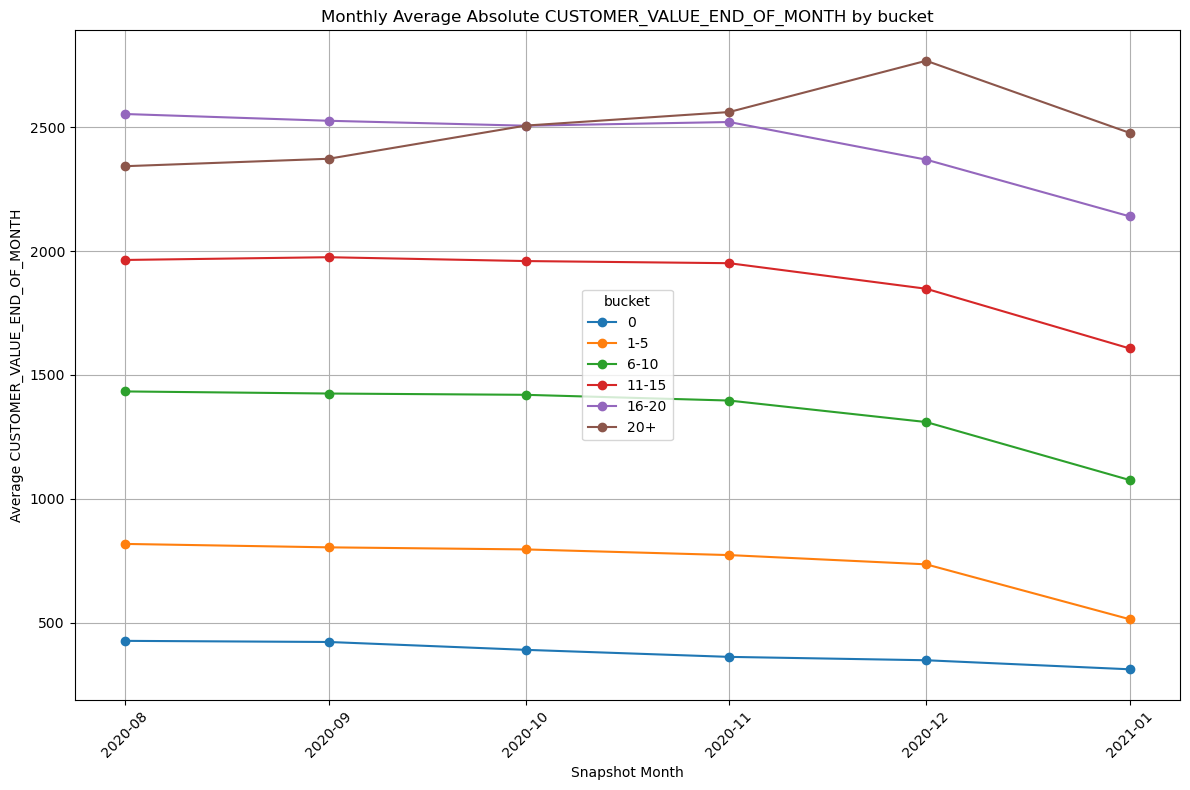

In [68]:

# Group by 'SNAPSHOT_MONTH' and 'bucket' and calculate the mean of the absolute 'CUSTOMER_CANCELLATION_DOLLARS'
monthly_avg_cancel_dollars = customerdf.groupby(['SNAPSHOT_MONTH', 'bucket'])['CUSTOMER_VALUE_END_OF_MONTH'].mean().reset_index()

# Pivot the data to have months as the rows and buckets as the columns
pivot_monthly_avg_cancel_dollars = monthly_avg_cancel_dollars.pivot(index='SNAPSHOT_MONTH', columns='bucket', values='CUSTOMER_VALUE_END_OF_MONTH')

# Plotting
plt.figure(figsize=(12, 8))

# Plot each bucket as a separate line on the chart
for column in pivot_monthly_avg_cancel_dollars.columns:
    plt.plot(pivot_monthly_avg_cancel_dollars.index, pivot_monthly_avg_cancel_dollars[column], marker='o', linestyle='-', label=column)

plt.title('Monthly Average Absolute CUSTOMER_VALUE_END_OF_MONTH by bucket')
plt.xlabel('Snapshot Month')
plt.ylabel('Average CUSTOMER_VALUE_END_OF_MONTH')
plt.legend(title='bucket')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()  # Adjust layout to prevent overlapping labels

plt.show()

/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_50901/2665188739.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_customer_value_by_bucket = customerdf.groupby('bucket')['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].mean()


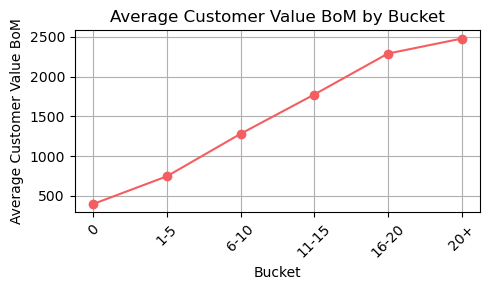

In [69]:
# Group by 'bucket' and calculate the average 'CUSTOMER_VALUE_BEGINNING_OF_MONTH' for each bucket
avg_customer_value_by_bucket = customerdf.groupby('bucket')['CUSTOMER_VALUE_BEGINNING_OF_MONTH'].mean()

# Create a line chart
plt.figure(figsize=(5, 3))
avg_customer_value_by_bucket.plot(kind='line', marker='o', color='#f55e61')

# Adding labels and title
plt.title('Average Customer Value BoM by Bucket')
plt.xlabel('Bucket')
plt.ylabel('Average Customer Value BoM')

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
customerdf.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R
136992,H49943112,2020-08-01,Basic,0,520.0,520.0,0.0,0,1.0
16737,H05941810,2020-08-01,Pro,7,1250.0,1300.0,0.0,6-10,1.0
229549,H83742451,2020-08-01,Pro,4,154.0,154.0,0.0,1-5,1.0
16720,H05941652,2020-08-01,Pro,4,50.0,50.0,0.0,1-5,1.0
16719,H05941535,2020-08-01,Pro,1,720.0,720.0,0.0,1-5,1.0


In [71]:
#Other ideas

##Consider looking at the lifelines package to make a survival curve if the data allows for it. make survival curves by integration buckets to see how much longer they retain by -- Would need cancellation rates though, not just C$R

##Do specific integrations have higher retention rates? 

#you can segment the customers by edition tier starter/pro/enterprise to understand the # of intergrrations. 

In [72]:
monthly_integration_counts = customerdf.groupby(['SNAPSHOT_MONTH', 'CUSTOMER_ID'])['NUM_OF_INTEGRATIONS'].sum().reset_index()

# Group by 'SNAPSHOT_MONTH' and calculate the average number of integrations per customer per month
avg_integration_per_customer_per_month = monthly_integration_counts.groupby('SNAPSHOT_MONTH')['NUM_OF_INTEGRATIONS'].mean()

# Display the result
print(avg_integration_per_customer_per_month)

SNAPSHOT_MONTH
2020-08-01    2.967965
2020-09-01    3.045464
2020-10-01    3.117919
2020-11-01    3.405470
2020-12-01    3.878537
2021-01-01    5.985213
Name: NUM_OF_INTEGRATIONS, dtype: float64


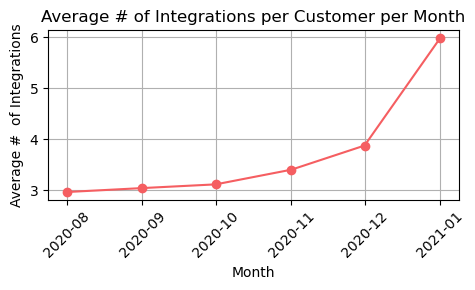

In [73]:
# Plotting
plt.figure(figsize=(5, 3))
plt.plot(avg_integration_per_customer_per_month.index, avg_integration_per_customer_per_month.values, marker='o', linestyle='-',color='#f55e61')
plt.title('Average # of Integrations per Customer per Month')
plt.xlabel('Month')
plt.ylabel('Average #  of Integrations')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

/var/folders/7k/pd956qlx413855s96xnwtlbm0000gp/T/ipykernel_50901/3156080586.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_csr_mean = customerdf.groupby('bucket')['C$R'].mean()


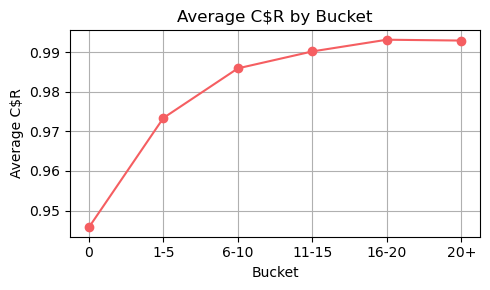

In [74]:
# Group by 'bucket' and calculate the mean of 'C$R'
bucket_csr_mean = customerdf.groupby('bucket')['C$R'].mean()

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(bucket_csr_mean.index, bucket_csr_mean.values, marker='o', linestyle='-', color='#f55e61')
plt.title('Average C$R by Bucket')
plt.xlabel('Bucket')
plt.ylabel('Average C$R')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

#Merge all 3 datasets to Jan 2021

In [75]:
customer_accounts_merge_2 = customerdf.merge(accountsdf, on='CUSTOMER_ID', how='left')


# Filter customer_and_accounts_df for January 2021
customer_and_accounts_jan_2021 = customer_accounts_merge_2[customer_accounts_merge_2['SNAPSHOT_MONTH'] == '2021-01-01']

# Filter integrationsdf for January 2021
integrations_jan_2021 = integrationsdf[integrationsdf['SNAPSHOT_MONTH'] == '2021-01-01']

# Perform a left join between the filtered DataFrames on 'CUSTOMER_ID'
merged_df = customer_and_accounts_jan_2021.merge(integrations_jan_2021, on='CUSTOMER_ID', how='left')

merged_df

,CUSTOMER_ID,SNAPSHOT_MONTH_x,PRODUCT_TIER,NUM_OF_INTEGRATIONS,CUSTOMER_VALUE_BEGINNING_OF_MONTH,CUSTOMER_VALUE_END_OF_MONTH,CUSTOMER_CANCELLATION_DOLLARS,bucket,C$R,EMPLOYEE_SIZE,CUSTOMER_SEGMENT,INTEGRATION_ID,SNAPSHOT_MONTH_y
0,H24942175,2021-01-01,Pro,2,100.0,0.0,100.0,1-5,0.0,1 to 25,International Direct,1,2021-01-01
1,H24942175,2021-01-01,Pro,2,100.0,0.0,100.0,1-5,0.0,1 to 25,International Direct,10,2021-01-01
2,H07143872,2021-01-01,Pro,5,640.0,640.0,0.0,1-5,1.0,26 to 200,NAM Partner,1,2021-01-01
3,H07143872,2021-01-01,Pro,5,640.0,640.0,0.0,1-5,1.0,26 to 200,NAM Partner,7,2021-01-01
4,H07143872,2021-01-01,Pro,5,640.0,640.0,0.0,1-5,1.0,26 to 200,NAM Partner,21,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275780,H40844500,2021-01-01,Pro,10,3121.0,3561.0,0.0,11-15,1.0,26 to 200,NAM Direct,Custom,2021-01-01
275781,H40844500,2021-01-01,Pro,10,3121.0,3561.0,0.0,11-15,1.0,26 to 200,NAM Direct,Custom,2021-01-01
275782,H40844500,2021-01-01,Pro,10,3121.0,3561.0,0.0,11-15,1.0,26 to 200,NAM Direct,Custom,2021-01-01
275783,H40844500,2021-01-01,Pro,10,3121.0,3561.0,0.0,11-15,1.0,26 to 200,NAM Direct,Custom,2021-01-01


/Users/lamiller/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lamiller/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lamiller/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lamiller/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

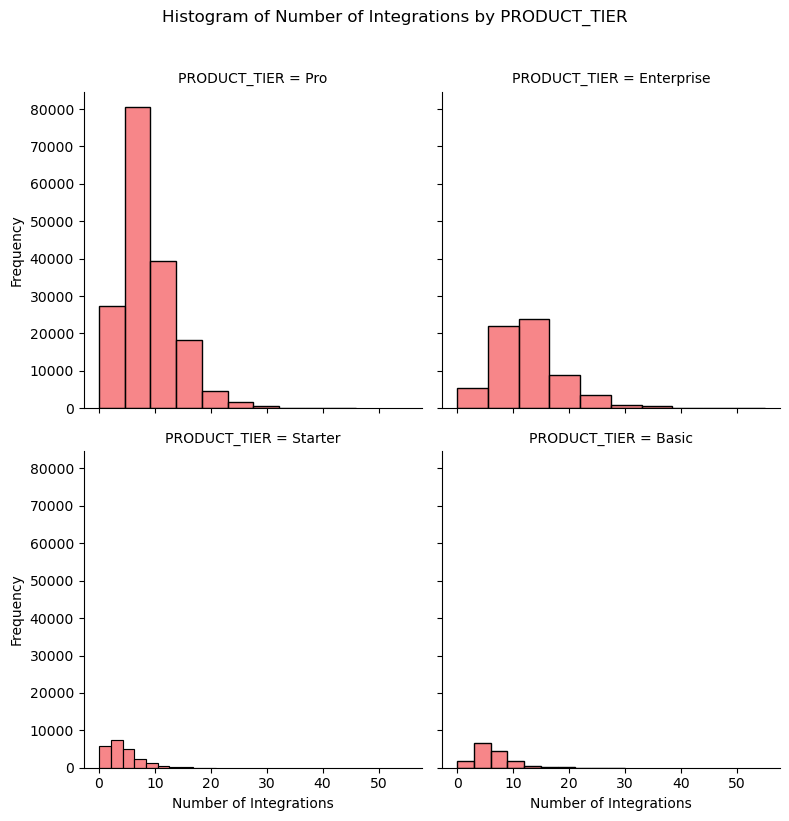

In [76]:
# Set up the facet grid
g = sns.FacetGrid(merged_df, col='PRODUCT_TIER', col_wrap=2, height=4)

# Create the histograms for each PRODUCT_TIER
g.map(sns.histplot, 'NUM_OF_INTEGRATIONS', bins=10,color='#f55e61')

# Adding labels and title
g.set_axis_labels('Number of Integrations', 'Frequency')
g.fig.suptitle('Histogram of Number of Integrations by PRODUCT_TIER', y=1.02)

# Show the plot
plt.tight_layout()
plt.show()

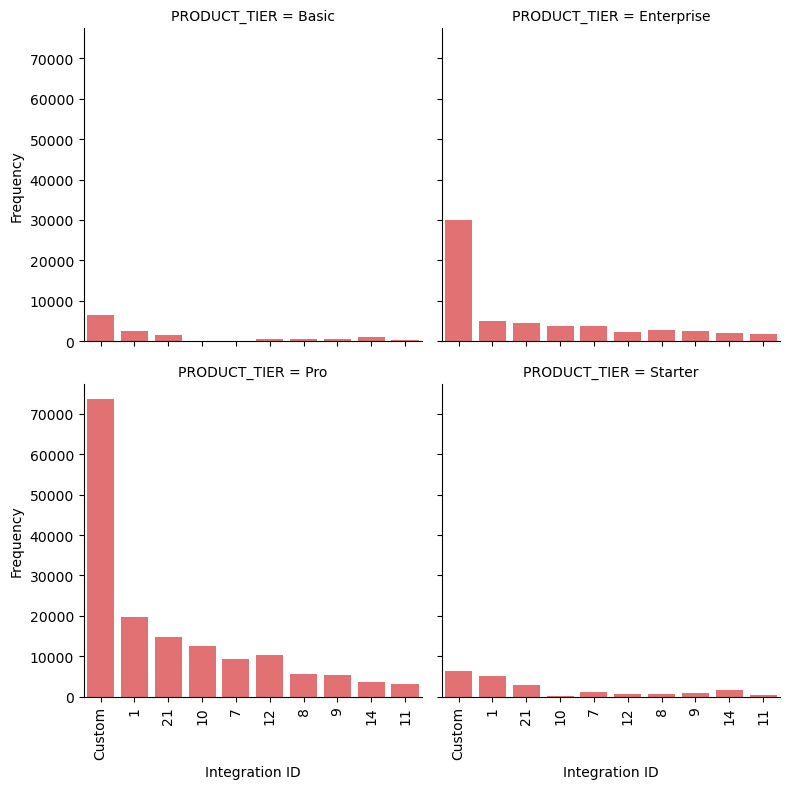

In [77]:
# Filter the DataFrame to include only the specified INTEGRATION_IDs
filtered_df = merged_df[merged_df['INTEGRATION_ID'].isin(['Custom', '1', '21', '10', '7', '12','8','9','14','11'])]

# Calculate the value counts of integration IDs within each PRODUCT_TIER
integration_id_counts = filtered_df.groupby(['PRODUCT_TIER', 'INTEGRATION_ID']).size().reset_index(name='count')

# Sort the integration ID counts within each PRODUCT_TIER by ascending order
integration_id_counts_sorted = integration_id_counts.sort_values(by=['PRODUCT_TIER', 'count'], ascending=[True, True])

# Define the order of the x-axis labels
integration_id_order = ['Custom', '1', '21', '10', '7', '12', '8', '9', '14', '11']

# Set up the facet grid
g = sns.FacetGrid(integration_id_counts_sorted, col='PRODUCT_TIER', col_wrap=2, height=4)

# Create the histograms for each PRODUCT_TIER, setting the order for the x-axis labels
g.map(sns.barplot, 'INTEGRATION_ID', 'count', color='#f55e61', order=integration_id_order)

# Rotate x-axis labels and ensure they are shown on all facets
for ax in g.axes.flat:
    ax.set_xticklabels(integration_id_order, rotation=90)

# Adding labels and title
g.set_axis_labels('Integration ID', 'Frequency')

# Adjust the plot to prevent layout issues
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Calculate the value counts of integration IDs
integration_id_counts = merged_df['INTEGRATION_ID'].value_counts()

# Get the top 10 integration IDs
top_10_integration_ids = integration_id_counts.head(10)

print("Top 10 Integration IDs:")
print(top_10_integration_ids)

Top 10 Integration IDs:
INTEGRATION_ID
Custom    116433
1          32154
21         23553
10         16465
7          14279
12         13681
8           9647
9           9190
14          8180
11          5661
Name: count, dtype: int64
